# Prévision de courbes de charge de consommation électrique

L’objectif de cet atelier est de construire un modèle afin de **prévoir la courbe de charge** de la consommation électrique d'un site, avec les contraintes suivantes : 
           
 - on souhaite une prédiction sur 3 jours
 - avec un intervalle d'1 jour par rapport à l'historique des données. 

Par exemple, les observations sur le site ID08 - hôtel ou hébergement similaire - s'arrêtent le 09/10/2012 à 23:30. Il s'agit donc de prévoir la courbe de charge de consommation pour les 11/10/2012, 12/10/2012 et 13/10/2012. 

L’atelier est scindé en 2 étapes :

* **Étape 1**. **Pré-traitement des données.**  
Cette étape contient :

    - L’import et l’audit des données : vérification rapide du contenu des fichiers de travail. Permet d’avoir une idée des méthodologies possibles à utiliser. 

    - Mise au format des données. En effet, pour étudier cette série temporelle, il va falloir découper les données en périodes (d'une durée à fixer) dont on va observer des réplicats (dans le temps).
    
* **Étape 2**. **Modélisation : apprentissage et test.**  
Plusieurs modélisations sont proposées :

    - Régression linéaire
    - Gradient Boosting : LightGBM
    - Random Forest


<a id='import'></a>
# Importer et auditer les données 

Les données à disposition sont contenues dans le fichier  `Courbes_Charge08.csv` à charger et qui contient 

   - la **consommation d'éléctricité** relevée **toutes les 10 minutes sur le site ID08**
   - la **température** sur le site ID08 relevée physiquement toutes les 3 heures. Les données sur les temps intermédiaires ont été complétées par interpolation linéaire. 

Avant d'importer le fichier, on peut  afficher les premières lignes avec la commande suivante :

In [1]:
%%bash
head -10 'data/Courbes_Charge08.csv'

DATE_LOCAL;Charge_ID08;Temp_ID08
01/01/2011 00:00;205;-0,7
01/01/2011 00:10;212;-0,716666667
01/01/2011 00:20;195;-0,733333333
01/01/2011 00:30;188;-0,75
01/01/2011 00:40;190;-0,766666667
01/01/2011 00:50;184;-0,783333333
01/01/2011 01:00;180;-0,8
01/01/2011 01:10;180;-0,816666667
01/01/2011 01:20;178;-0,833333333


Si la commande précédente ne fonctionne pas sur votre OS :

In [2]:
file = open('data/Courbes_Charge08.csv', 'r')
for i, line in zip(range(5), file):
   print(i, line)

0 DATE_LOCAL;Charge_ID08;Temp_ID08

1 01/01/2011 00:00;205;-0,7

2 01/01/2011 00:10;212;-0,716666667

3 01/01/2011 00:20;195;-0,733333333

4 01/01/2011 00:30;188;-0,75



Notez qu'on ne sait pas si les dates sont codées en jour/mois/année ou mois/jour/année. On peut le voir en affichant une ligne un peu plus loin : 

In [3]:
for i, line in enumerate(file):
    if i == 4000:
        print(i, line)
        break

4000 28/01/2011 19:20;124;0,166666667



Là on constate qu'il s'agit d'un codage jour/mois/année.

### Exercice 1

Importez les données dans un dataframe (de la bibliothèque `pandas`) nommé `df` : 
* L'option `parse_dates` de la fonction `read_csv` de pandas vous permet de lire correctement la variable de la date.  
* Faites attention au format de la température. 
* On transformera les noms de variables en minuscules (usage python). 

Puis familiarisez-vous avec ces données (à l'aide de `shape`, `head`, `dtypes`, `describe`,...).    
Pendant combien de jours sont mesurées les données du site ? 


À l'aide de la librairie `matplotlib`, tracez les courbes de charge et de température en fonction de la date. Zoomez la courbe de charge en faisant varier la date de début et la durée de l'observation (pour mémoire, 1 jour = 6x24 points), l'objectif étant de comprendre les périodicités de cette courbe.  

In [4]:
# Your answer

### Réponse

In [5]:
import os
import numpy as np
import pandas as pd

# Votre chemin. Par defaut celui du notebook
# path_data = '.'
path_data = 'data/'
    
df = pd.read_csv(os.path.join(path_data, 'Courbes_Charge08.csv'), 
                 sep=';', 
                 parse_dates=['DATE_LOCAL'],
                 decimal=',',  # les décimales sont codées par une virgule
                 dayfirst=True, # the day appears before month
                 infer_datetime_format=True)

# L'usage en Python est de mettre les noms de variables en minuscule 
df.columns = [x.lower() for x in df.columns]

In [6]:
df.head()

,date_local,charge_id08,temp_id08
0,2011-01-01 00:00:00,205,-0.700000
1,2011-01-01 00:10:00,212,-0.716667
2,2011-01-01 00:20:00,195,-0.733333
3,2011-01-01 00:30:00,188,-0.750000
4,2011-01-01 00:40:00,190,-0.766667


In [7]:
df.tail()

,date_local,charge_id08,temp_id08
93307,2012-10-09 23:10:00,83,15.061111
93308,2012-10-09 23:20:00,82,14.988889
93309,2012-10-09 23:30:00,76,14.916667
93310,2012-10-09 23:40:00,81,14.844444
93311,2012-10-09 23:50:00,54,14.772222


Les données du site id08 débutent le 1er janvier 2011 à minuit et s'achèvent le 09 octobre 2012 à 23:50. Elles sont régulières et contiennent des mesures toutes les 10 minutes. 


In [8]:
df.shape

(93312, 3)

Avec des mesures toutes les 10 mins, on doit avoir 6 mesures par heure et 6*24 mesures par jour. Les 93312 lignes correspondent donc à 648 jours, ce qui fait bien 1 an (365 jours) plus 283 jours ; soit 1 an, 40 semaines et 3 jours.  

In [9]:
df.dtypes

date_local     datetime64[ns]
charge_id08             int64
temp_id08             float64
dtype: object

In [10]:
df.columns

Index(['date_local', 'charge_id08', 'temp_id08'], dtype='object')

In [11]:
df.describe()

,charge_id08,temp_id08
count,93312.000000,93312.000000
mean,71.723615,11.696754
std,29.776986,5.731311
min,21.000000,-8.700000
25%,49.000000,7.944444
50%,62.000000,11.733333
75%,88.000000,15.722222
max,260.000000,31.500000


In [12]:
# description IT des données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93312 entries, 0 to 93311
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date_local   93312 non-null  datetime64[ns]
 1   charge_id08  93312 non-null  int64         
 2   temp_id08    93312 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB


On trace les courbes de charge et de température en fonction de la date : 

<AxesSubplot:xlabel='date_local'>

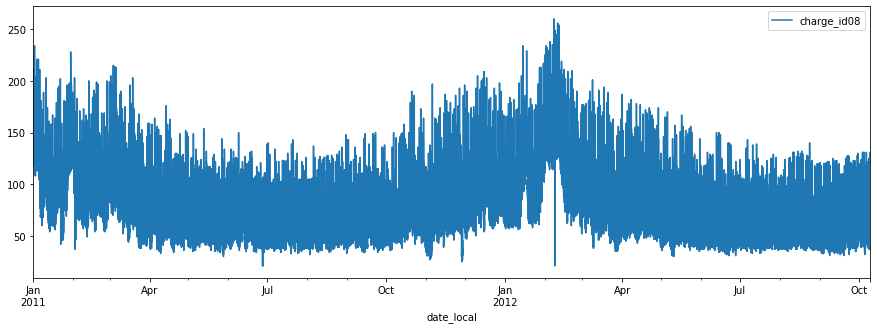

In [13]:
from matplotlib import pyplot as plt
# Pour afficher le plot dans le notebook
%matplotlib inline

df.plot(x='date_local', y='charge_id08', figsize=(15, 5))

<AxesSubplot:xlabel='date_local'>

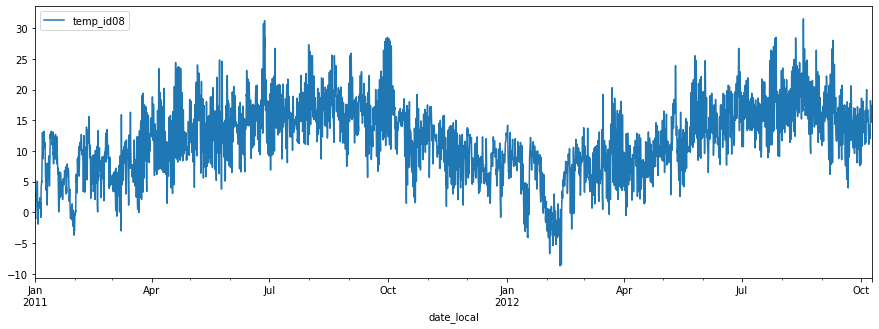

In [14]:
df.plot(x='date_local', y='temp_id08', figsize=(15, 5))

Nous allons zoomer les courbes de charge en faisant varier la date de départ et la durée des périodes (rappel 1 jour = 6*24 points), l'objectif étant de comprendre les périodicités de cette courbe.

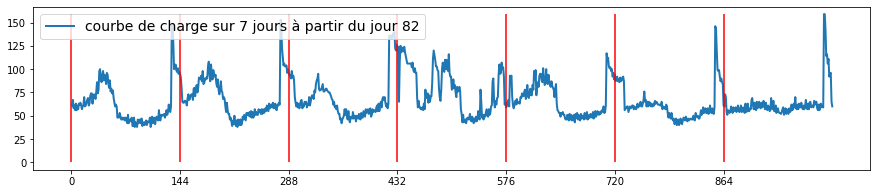

In [15]:
# On fera varier les deux quantités ci-dessous
j_deb = 82 # n'importe quoi entre 0 et 648 moins la durée d'observation
j_dur = 7 # regardons sur une semaine de temps

# 
debut = 6*24*j_deb # point de départ 
duree = 6*24*j_dur
fig = plt.figure(figsize=(15, 3))
x = np.linspace(1, duree, duree)
plt.plot(x, df["charge_id08"].iloc[debut:(debut+duree)], label="courbe de charge sur %.f jours à partir du jour %.f" %(j_dur, j_deb), lw=2)
# séparateur de jours
plt.xticks(np.arange(0, max(x), 6*24))
plt.vlines(np.arange(0, max(x), 6*24),0,max(df["charge_id08"].iloc[debut:(debut+duree)]),color='red')
plt.legend(fontsize=14, loc='upper left')

Rappel : Une journée contient 6x24=144 points et une semaine en contient 1008. On a tracé ci-dessus les périodes quotidiennes. On voit que certains jours ont des profils identiques, mais pas tous. 

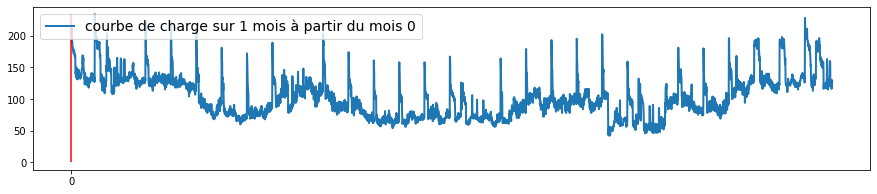

In [16]:
# On regarde les choses à l'échelle mensuelle
# On fera varier les deux quantités ci-dessous
m_deb = 0 # n'importe quoi entre 0 et 22 moins la durée d'observation
m_dur = 1 # regardons pendant un nobre de mois fixé

# On se fixe des mois à 30 jours 
debut = 6*24*30*m_deb # point de départ 
duree = 6*24*30*m_dur
fig = plt.figure(figsize=(15, 3))
x = np.linspace(1, duree, duree) 
plt.plot(x, df["charge_id08"].iloc[debut:(debut+duree)], label="courbe de charge sur %.f mois à partir du mois %.f" %(m_dur, m_deb), lw=2)
# séparateur de mois : 
plt.xticks(np.arange(0, max(x), 6*24*30)) 
plt.vlines(np.arange(0, max(x), 6*24*30),0,max(df["charge_id08"].iloc[debut:(debut+duree)]),color='red')
plt.legend(fontsize=14, loc='upper left')

Conclusion : à l'échelle mensuelle on ne voit pas grand chose (sauf peut-être l'hiver et l'été).

# Mise au format des données


## Utilisation des données calendaires

Dans cette partie, nous utilisons le module `datetime` afin de créer des champs de variables calendaires (pour une étude plus avancée). 

### Exercice 2
On définit donc les 3 variables suivantes : 
* identifiant de jour (de 1 à 648 sur ces données)
* type de jour (lundi, mardi,...)
* un code du type de jour (de 0 à 6 pour lundi à dimanche)


In [17]:
import datetime

# On ajoute la colonne qui donne un id unique du jour

# Pour cela on écrit une fonction qui donne le nombre exact de jours dans 
# une année donnée
def n_days_in_year(year):
    d1 = datetime.date(year, 1, 1) 
    d2 = datetime.date(year + 1, 1, 1) 
    return (d2 - d1).days

# L'année la plus ancienne dans le jeux de données
min_year = df['date_local'].dt.year.min()

# Une fonction qui renvoie un numéro unique de jour 
def day_number(t):
    n_days = 0
    for y in range(min_year, t.year):
        n_days += n_days_in_year(y)      
    return n_days + t.dayofyear

# On ajoute à notre jeu de données une colonne avec numero du jour
col_jour = df['date_local'].apply(day_number)
df.insert(loc=0, column='jour', value=col_jour)

In [18]:
# On ajoute également une colonne qui donne le nom du jour
day_name = df['date_local'].dt.day_name()
df.insert(loc=1, column='type_jour', value=day_name)

# Création de codes pour le type de jour
day_num = df['date_local'].dt.dayofweek
df.insert(loc=2, column='code_jour', value=day_num)

# Visualisons le nouveau jeu de données
df.head()

,jour,type_jour,code_jour,date_local,charge_id08,temp_id08
0,1,Saturday,5,2011-01-01 00:00:00,205,-0.700000
1,1,Saturday,5,2011-01-01 00:10:00,212,-0.716667
2,1,Saturday,5,2011-01-01 00:20:00,195,-0.733333
3,1,Saturday,5,2011-01-01 00:30:00,188,-0.750000
4,1,Saturday,5,2011-01-01 00:40:00,190,-0.766667


In [19]:
df.tail()

,jour,type_jour,code_jour,date_local,charge_id08,temp_id08
93307,648,Tuesday,1,2012-10-09 23:10:00,83,15.061111
93308,648,Tuesday,1,2012-10-09 23:20:00,82,14.988889
93309,648,Tuesday,1,2012-10-09 23:30:00,76,14.916667
93310,648,Tuesday,1,2012-10-09 23:40:00,81,14.844444
93311,648,Tuesday,1,2012-10-09 23:50:00,54,14.772222


In [20]:
df['code_jour'].unique()

array([5, 6, 0, 1, 2, 3, 4])

## Formatage de la série temporelle - Étape importante : choix de la periode

Dans cette partie, on va découper la série temporelle en série  d'observations successives sur une période fixée. Ces différentes périodes seront ensuite considérées comme des réplicats.  Il faut donc choisir une période qui fait du sens vis-à-vis de la variable étudiée (ici la courbe de charge). Il faudra aussi choisir une période de façon à avoir assez de réplicats (par exemple travailler à l'échelle annuelle n'est pas possible avec ces données). 




### Exercice 3

Définissez une variable `periode`, exprimée en jours, qui pourra prendre par exemple les valeurs 1 (courbes de charge quotidiennes) ou 7 (courbes de charge hebdomadaires) ou tout autre choix. Pour cette variable, vous allez calculer :
* `nobs` le nombre de points de mesure correspondant à cette période
* `n` le nombre **entier** de périodes contenues dans les données. 

Ensuite, vous allez :
- supprimer les données les plus anciennes de manière à avoir un nombre entier de périodes d'observation 
- sauver le tableau de travail sous un nouveau nom `df2`.

In [21]:
# Your answer

### Réponse

In [22]:
## On fixe la periode en jours - faites varier la période
#periode = 1 # On peut travailler sur des consommations journalières
periode = 7 # Ou sur des consommations hebdomadaire

In [23]:
# Nombre de points d'observation necessaires pour 1 période (exprimée en jours)
nobs = periode * 6 * 24

# Nombre de periodes disponibles dans les donnees
n = int(df.shape[0] / nobs)

In [24]:
# On supprime des données de manière à disposer d'un nombre entier de périodes d'observation

# Nombre de lignes a supprimer (on choisit de les supprimer au debut de la période d'observation)
kill = df.shape[0] - n * nobs

# On définit un nouveau tableau en supprimant la période incomplète du début 
df2 = df.iloc[kill:df.shape[0]]

# Comptages divers
print("Chaque période contient %.f points de mesure" %nobs)
print("Il y a un total de %.f périodes" %n)
print("On a supprimé %.f points d'observation en début de série" %kill)
print("Les nouvelles données contiennent %.f points de mesure" %df2.shape[0])

Chaque période contient 1008 points de mesure
Il y a un total de 92 périodes
On a supprimé 576 points d'observation en début de série
Les nouvelles données contiennent 92736 points de mesure


In [25]:
# Visualisons l'en-tête des nouvelles données
df2.head()

,jour,type_jour,code_jour,date_local,charge_id08,temp_id08
576,5,Wednesday,2,2011-01-05 00:00:00,122,1.700000
577,5,Wednesday,2,2011-01-05 00:10:00,124,1.683333
578,5,Wednesday,2,2011-01-05 00:20:00,124,1.666667
579,5,Wednesday,2,2011-01-05 00:30:00,125,1.650000
580,5,Wednesday,2,2011-01-05 00:40:00,133,1.633333


Rappelons que l'objectif final est la prédiction de la charge en fonction de l'historique. Pour cela, nous considérerons un modèle linéaire dans lequel on souhaite  prédire la nouvelle charge à un moment précis de la période (p.ex. un mardi à 15h10, si on considère des périodes d'une semaine) en fonction de toutes les charges et temperatures observées dans le passé au même moment (tous les mardis à 15h10). 

### Exercice 4

- Mettre les données au bon format maintenant.  Commencer par les données de la charge. On construira un nouveau tableau de données, appelé `df_charge`, qui contient`nobs`  lignes (= nombre de points par période) et `n` colonnes (= nombre de périodes). 
  Vous nommerez les colonnes de `C1` (la plus ancienne) à `Cn` (la plus récente).
- En utilisant ce nouveau tableau, tracez sur un même graphique la  superposition de quelques courbes de charge sur la période donnée.
- Faites varier la période.
- Effectuer la même démarche pour la température. Vous nommerez le nouveau tableau `df_temp` et  les colonnes `T1` à `Tn` avec la même convention.


In [26]:
# Your answer

### Réponse

In [27]:
# Reformater la variable charge_id08 en une suite de périodes successives
mat_tmp = np.array(df2['charge_id08']).reshape(n, nobs).T
# ici mat_tmp est un numpy array et donc ce n'est pas un DataFrame (pandas)
# ce n'est pas grave car on peut faire du sklearn avec des numpy arrays
# Mais les statisticiens aiment les DataFrames donc on transforme et on ajoute des noms de colonne
noms = [f'C{i}' for i in range(1, n + 1)]
df_charge = pd.DataFrame(mat_tmp,columns = noms)

In [28]:
# Le nouveau tableau a nobs lignes et n colonnes
print(df_charge.shape)
print(nobs,n)

(1008, 92)
1008 92


In [29]:
# Visualisons le haut du nouveau tableau
df_charge.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92
0,122,116,100,106,93,71,124,126,141,81,...,79,90,94,103,87,87,82,72,42,62
1,124,119,108,122,105,72,120,133,115,85,...,78,86,97,110,83,88,80,72,43,43
2,124,104,91,124,94,73,120,127,113,83,...,79,85,95,107,84,84,82,71,44,51
3,125,118,100,111,97,76,120,125,111,75,...,79,82,90,107,85,88,83,72,44,45
4,133,120,105,120,94,72,118,118,100,86,...,76,80,94,112,86,87,79,71,45,50


In [30]:
print("Il y a correspondance entre la variable C1 et la charge de la période 1")
df2.head()

Il y a correspondance entre la variable C1 et la charge de la période 1


,jour,type_jour,code_jour,date_local,charge_id08,temp_id08
576,5,Wednesday,2,2011-01-05 00:00:00,122,1.700000
577,5,Wednesday,2,2011-01-05 00:10:00,124,1.683333
578,5,Wednesday,2,2011-01-05 00:20:00,124,1.666667
579,5,Wednesday,2,2011-01-05 00:30:00,125,1.650000
580,5,Wednesday,2,2011-01-05 00:40:00,133,1.633333


Visualisons les charges de quelques périodes choisies arbitrairement.

C11 débute le : Wednesday 2012-08-01 00:00:00
C20 débute le : Wednesday 2012-05-30 00:00:00
C9 débute le : Wednesday 2012-08-15 00:00:00
C28 débute le : Wednesday 2012-04-04 00:00:00
C7 débute le : Wednesday 2012-08-29 00:00:00
C53 débute le : Wednesday 2011-10-12 00:00:00


<Figure size 1296x432 with 0 Axes>

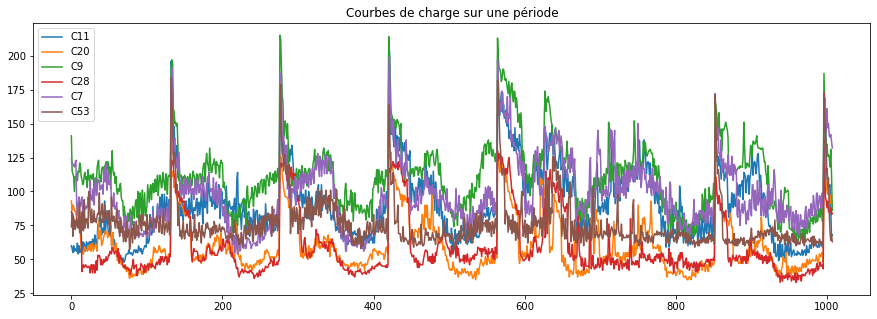

In [31]:
# Visualisation graphique de quelques périodes 
P0 = [10,19,8,27,6,52] # on choisit des indices de périodes  
periodes = df_charge.columns[P0]

fig = plt.figure(figsize=(18, 6))
df_charge.plot(y=periodes, figsize=(15, 5), title='Courbes de charge sur une période')

for i in range(len(periodes)): 
    a = (n - P0[i])*periode + int(kill/6/24)+1   # on démarre au jour d'indice kill/(6*24)+1
    toto = df2[df2['jour'] == a]
    print(periodes[i], 'débute le :',toto.iloc[0,1],toto.iloc[0,3])
    

On fait la même chose sur la variable température.

In [32]:
# Reformater la variable temp_id08
mat_tmp = np.array(df2['temp_id08']).reshape(n, nobs).T
noms = [f'T{i}' for i in range(1, n + 1)]
df_temp = pd.DataFrame(mat_tmp,columns = noms)
df_temp.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T83,T84,T85,T86,T87,T88,T89,T90,T91,T92
0,1.700000,4.400000,1.400000,6.500000,4.700000,8.50,3.000000,3.7,4.300000,5.000000,...,12.800000,11.9,20.100000,13.700000,13.600000,16.300000,12.500000,8.900000,11.000000,13.30
1,1.683333,4.477778,1.327778,6.466667,4.694444,8.45,3.033333,3.6,4.294444,4.972222,...,12.738889,11.9,20.027778,13.644444,13.477778,16.277778,12.461111,8.872222,10.933333,13.35
2,1.666667,4.555556,1.255556,6.433333,4.688889,8.40,3.066667,3.5,4.288889,4.944444,...,12.677778,11.9,19.955556,13.588889,13.355556,16.255556,12.422222,8.844444,10.866667,13.40
3,1.650000,4.633333,1.183333,6.400000,4.683333,8.35,3.100000,3.4,4.283333,4.916667,...,12.616667,11.9,19.883333,13.533333,13.233333,16.233333,12.383333,8.816667,10.800000,13.45
4,1.633333,4.711111,1.111111,6.366667,4.677778,8.30,3.133333,3.3,4.277778,4.888889,...,12.555556,11.9,19.811111,13.477778,13.111111,16.211111,12.344444,8.788889,10.733333,13.50


T11 débute le : Wednesday 2012-08-01 00:00:00
T10 débute le : Wednesday 2012-08-08 00:00:00
T9 débute le : Wednesday 2012-08-15 00:00:00
T8 débute le : Wednesday 2012-08-22 00:00:00
T7 débute le : Wednesday 2012-08-29 00:00:00
T6 débute le : Wednesday 2012-09-05 00:00:00


<Figure size 1296x432 with 0 Axes>

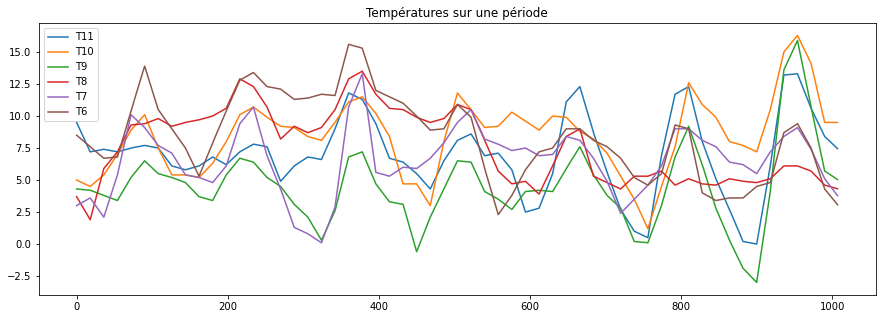

In [33]:
# Courbes de température pour quelques périodes
P0 = [10,9,8,7,6,5]
periodes = df_temp.columns[P0]

fig = plt.figure(figsize=(18, 6))
df_temp.plot(y=periodes, figsize=(15, 5), title='Températures sur une période')

# Pour chaque période, on indique à quel jour de la semaine et quelle date elle débute

for i in range(len(periodes)):    
    a = (n - P0[i])*periode + int(kill/6/24)+1   # on démarre au jour d'indice kill/(6*24)+1
    toto = df2[df2['jour'] == a]
    print(periodes[i], 'débute le :',toto.iloc[0,1],toto.iloc[0,3])


## Premières questions de modélisation

Nous allons apprendre la courbe de charge $C_k$ de la période numéro $k$ à l'aide des courbes de charge $C_{k-1}, C_{k-2}, \ldots$ des périodes passées numéro $k-1, k-2, \ldots$.

Attention, le problème initial imposé est de proposer une prévision :
   - d'une durée 3 jours ;
   - avec un intervalle d'1 jour par rapport à l'historique des données. 

### Exercice 5

1. Une modélisation *à la journée* est-t-elle judicieuse à votre avis ? Étudiez cette question : 
    -  en observant le comportement des différents types de jours ;
    -  en pensant à l'objectif : prévision sur 3 jours avec un intervalle d'1 jour.


2. Choisir de modéliser *à la semaine* plutôt qu'*à la journée* ne semble-t-il pas plus pertinent ? Pourquoi ? 

3. Quelles variables explicatives pourrait-on inclure dans le modèle ?


Your answer:

### Réponse


1. Non ce n'est pas judicieux car les jours ont des comportements différents (typiquement le dimanche a un profil de courbe de charge très différent). 

2. Modéliser à la semaine est donc plus intéressant, puisque la périodicité des comportements est sur 7 jours. 

3. Il est naturel et même obligatoire d'inclure la température comme variable explicative. 


**Refaites tourner le code ci-dessus en choisissant une période de 7 jours avant de passer à la suite.** 

# Modélisation

**NB** : Pour tous les modèles proposés, il faut choisir la profondeur de l'historique selon :
- les possibilités techniques ;
- le sens "métier".

On commence par choisir une période (ici une semaine) d'indice $k$  et par entraîner le modèle linéaire pour prévoir la courbe de charge sur la période (semaine) qui suit immédiatement la période $k$, i.e la période d'indice $k+1$. Autrement dit on va d'abord apprendre le lien entre $C_k$ et les courbes de charges précedentes $C_{k-1},C_{k-2},\dots,C_{k-h}$ ainsi que les températures associées $T_{k-1},\dots,T_{k-h}$, pour un certain choix de l'historique $h$.
Ensuite, on utilisera cette relation apprise pour prédire la courbe de charge $C_{k+1}$ en fonction de $C_{k},C_{k-1},\dots,C_{k-h+1}$. On évaluera les mêmes erreurs que précedemment entre la courbe prédite et la courbe réelle. 

La qualité de la méthode sera évaluée en faisant varier $k$ (la semaine de référence) et $h$ (selon la longueur des données dont on dispose).

## Estimation par régression linéaire

Dans cette première partie, on suppose que le lien entre  $C_k$ et les variables $C_{k-1},C_{k-2},\dots,C_{k-h}, T_{k-1},\dots,T_{k-h}$ est donnée par une simple fonction linéaire, qu'on va apprendre en faisant la régression.

### Exercice 6

1. À l'aide de la fonction `LinearRegression` du module `sklearn.linear_model` faites une régression linéaire de la variable $C_k$ (qu'on renommera en `y_train`) sur les variables $C_{k-1},\dots C_{k-h}, T_{k-1},\dots,T_{k-h}$ (qu'on renommera en `x_train`). 

2. Ensuite, grâce à cette relation apprise, vous prédirez la variable $C_{k+1}$ (renommée `y_test`) à partir des $h$ variables immédiatement précédentes, c'est-à-dire $C_{k},\dots C_{k-h+1},T_k,\dots, T_{k-h+1}$ (renommées `x_test`).

3. La qualité de la prédiction sera mesurée en erreur relative pour la norme $L_1$ ainsi que via la racine carrée de l'erreur quadratique moyenne (via la fonction `mean_squared_error` du module `sklearn.metrics`). 
Vous calculerez également la corrélation de Pearson entre les valeurs prédites et les valeurs observées via  la fonction `pearsonr` du module `scipy.stats`.
4. Vous tracerez les courbes prédites et observées pour visualiser la qualité de la prédiction. 

In [34]:
# Your answer

### Réponse

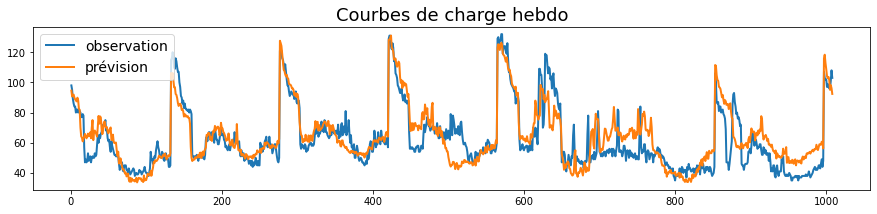

RMSE: 11.0630
MAPE: 0.1446
Correlation observation/prevision: 0.8538


In [35]:
### Modèle Auto-régressif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr 

# Choisir le numero k de periode
# Apprendre le lien entre Ck et son passe C_{k-1}...C_{k-h}, T_{k-1}...T_{k-h}
# Prevoir la periode suivante C_{k+1}

# Numero de colonne du debut la periode d'apprentissage 
k = 22
# Nombre de periodes (semaines) passées, ie historique utilisé
h = 4

# Creation du modele
lr = LinearRegression()

# Données TEST et TRAIN
y_train = df_charge.iloc[:, k]
x_train = pd.concat([df_charge.iloc[:, (k-h):(k-1)], # courbes de charge de l'historique
                     df_temp.iloc[:, (k-h):(k-1)]], axis=1) # courbes de température de l'historique
y_test = df_charge.iloc[:, (k+1)]
x_test = pd.concat([df_charge.iloc[:, (k-h+1):k],
                     df_temp.iloc[:, (k-h+1):k]], axis=1) # nouvel historique

# Rename columns - Necessary !!!
x_test.columns = x_train.columns

# Estimer le modèle
lr.fit(x_train, y_train)
# prédire sur données test
pred=lr.predict(x_test)

#############
# Graphes de prédiction sur toute la période
fig = plt.figure(figsize=(15, 3))

x = np.linspace(1, nobs, nobs)
plt.plot(x, y_test, label="observation", lw=2)
plt.plot(x, pred, label="prévision", lw=2)
plt.title('Courbes de charge hebdo', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

plt.show()

# Root mean square error
rmse = mean_squared_error(y_test, pred) ** 0.5 # racine carrée de la MSE
print("RMSE: %.4f" % rmse)
# Mean absolute prediction error
mape = (abs((pred - y_test) / y_test)).mean()
print("MAPE: %.4f" % mape)
cor = pearsonr(y_test, pred)
print("Correlation observation/prevision: %.4f" % cor[0])

Notez que le problème des mesures RMSE et MAP est qu'elles ne sont pas facilement interprétables (combien vaut un 'bon RMSE' ?). Il faut faire varier les valeurs de $h$ et de $k$ (c'est ce qu'on fera ci-dessous) pour trouver le 'meilleur' ajustement.  



### Exercice 7

Avec cette approche, répondez à la demande initiale de prédiction sur 3 jours avec un intervalle d'un jour. Plus précisément, grâce à la relation apprise ci-dessus entre la courbe de la semaine $k$ et celles des $h$ semaines précédentes, vous avez obtenu une prédiction pour *toute la semaine* $k+1$ et vous pouvez en extraire les prédictions pour les jours numéros 2 à 4 de cette semaine. Vous tracerez les courbes prédites et observées et calculerez les mêmes erreurs que précédemment restreintes aux 3 jours qui nous intéressent.

In [36]:
# Your answer

### Réponse

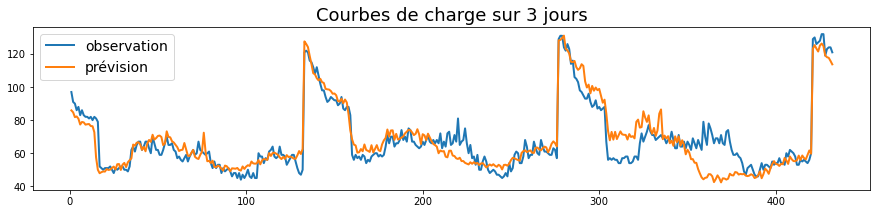

RMSE: 8.5465
MAPE: 0.0943
Correlation observation/prevue: 0.9069


In [37]:
# Prédiction demandée : 3 jours avec un intervalle de 1 jour ==> restriction de la prédiction

gap = 1
horizon = 3 
debut = gap * 6 * 24 # première mesure (commence le second jour de la période)
fin = debut + horizon * 6 * 24 # dernière mesure (finit le quatrième jour de la période)

fig = plt.figure(figsize=(15, 3))

npoints = fin-debut
x = np.linspace(1, npoints, npoints)
# On extrait de y_test les points entre 
plt.plot(x, y_test[debut:fin], label="observation", lw=2)
plt.plot(x, pred[debut:fin], label="prévision", lw=2)
plt.title('Courbes de charge sur 3 jours', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

plt.show()

rmse = mean_squared_error(y_test[debut:fin], pred[debut:fin]) ** 0.5
print("RMSE: %.4f" % rmse)
mape = (abs((pred[debut:fin] - y_test[debut:fin]) /y_test[debut:fin])).mean()
print("MAPE: %.4f" % mape)
cor = pearsonr(y_test[debut:fin], pred[debut:fin])
print("Correlation observation/prevue: %.4f" % cor[0])

On va à présent pour un historique $h$ fixé regarder toutes les prévisions possibles, i.e. faire varier $k$ sur l'ensemble des valeurs possibles.

In [38]:
range(n-h)

range(0, 88)

RMSE: 14.7258
MAPE: 0.1689
Corr: 0.8300


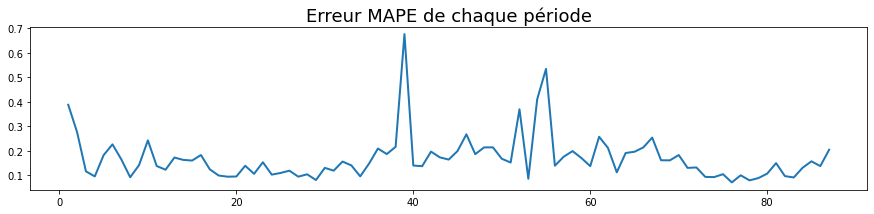

In [39]:
# Modelisation lineaire systématique sur toutes les périodes k

# Initialisation des erreurs
E2_lr = []
E1_lr = []
Cor_lr = []

# Toutes les prévisions de h+1 à (Période_Max - h)
for i in range(n-h-1):
    k = i + h

    # Données TEST et TRAIN
    y_train = df_charge.iloc[:, k]
    x_train = pd.concat([df_charge.iloc[:, (k-h):(k-1)], 
                     df_temp.iloc[:, (k-h):(k-1)]], axis=1) 
    y_test = df_charge.iloc[:, (k+1)]
    x_test = pd.concat([df_charge.iloc[:, (k-h+1):k],
                     df_temp.iloc[:, (k-h+1):k]], axis=1) 

                     
    # Modélisation
    x_test.columns = x_train.columns
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    
    # Performances
    err2 = mean_squared_error( pred[debut:fin], y_test[debut:fin]) ** 0.5
    mape = (abs(( pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin],  pred[debut:fin])
    Cor_lr.append(cor[0]) 
    E2_lr.append(err2)
    E1_lr.append(mape)
    

#########
# Résultats
from statistics import mean

plt.figure(figsize=(15, 3))
x = np.linspace(1, len(E1_lr), len(E1_lr))
plt.plot(x, E1_lr, label="erreur", lw=2)
plt.title('Erreur MAPE de chaque période', fontsize=18)

print("RMSE: %.4f" % mean(E2_lr))
print("MAPE: %.4f" % mean(E1_lr))
print("Corr: %.4f" % mean(Cor_lr))

### Exercice 8 (à la maison)
Avec le code ci-dessus, faites varier $h$ et choisissez l'historique le mieux adapté à l'ensemble des périodes.

In [40]:
# Your answer

## Forêts aléatoires 

Dans cette partie, on va encore chercher le lien entre  $C_k$ et les courbes de charges précedentes $C_{k-1},C_{k-2},\dots,C_{k-h}$ ainsi que les températures associées $T_{k-1},\dots,T_{k-h}$. Mais cette fois, le lien entre ces variables sera appris par des arbres de décision ; plus précisémment, par des forêts aléatoires. 

### Exercice 9

Vous allez à présent utiliser des forêts aléatoires via le module `RandomForestRegressor` de `sklearn.ensemble` pour apprendre un modèle prédictif pour le même problème et les mêmes données qu'avant. 

Explorez les paramètres de la fonction `RandomForestRegressor`.

Procédez comme précédemment : 
- apprendre pour une semaine fixée $k$, avec un historique $h$, puis prédire la semaine $k+1$. Calculez différentes erreurs pour cette période.  
- calculez les erreurs moyennes sur toutes les périodes disponibles.


In [41]:
# Your answer

### Réponse

RMSE: 11.7788
MAPE: 0.1593
Correlation observation/prevue: 0.7848


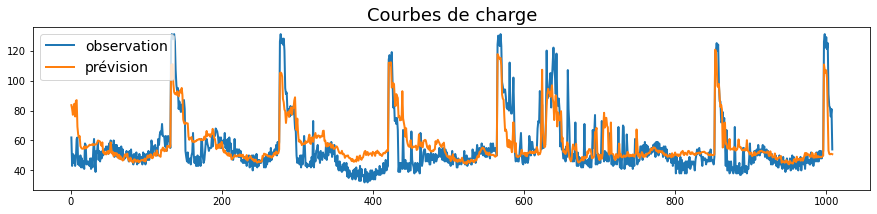

In [42]:
# Modelisation Random Forest

# Choisir k numero de periode
# Apprendre le lien Pk et son passe
# Prevoir Pk+1

from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

# Numero colonne du debut la periode d'apprentissage ==> K+1 à prévoir
K = 22

# Nombre de periodes passees : historique utilisé
h = 4

#creation du modele
rf = RandomForestRegressor(
    n_estimators=100, # Nombre d'échantillons bootstrap et d'arbres
    max_features=0.2, #  round(max_features * n_features) features are considered at each split (The default of 1.0 is equivalent to bagged trees)
    max_depth=10,      # profondeur max de l'arbre
    random_state=2,    # on règle une graine pour avoir tous les mêmes résultats
    oob_score=True # Whether to use out-of-bag samples to estimate the generalization score. 
)

y_train = df_charge.iloc[:, k]
x_train = pd.concat([df_charge.iloc[:, (k-h):(k-1)], 
                     df_temp.iloc[:, (k-h):(k-1)]], axis=1) 
y_test = df_charge.iloc[:, (k+1)]
x_test = pd.concat([df_charge.iloc[:, (k-h+1):k],
                     df_temp.iloc[:, (k-h+1):k]], axis=1) 

# attention aux noms des colonnes
x_test.columns = x_train.columns

# On ajuste le modèle
rf.fit(x_train, y_train)
# On prédit la période suivante 
pred = rf.predict(x_test)

mse = mean_squared_error(y_test, pred) ** 0.5
print("RMSE: %.4f" % mse)
map1 = (abs((pred - y_test) / y_test)).mean()
print("MAPE: %.4f" % map1)
cor = pearsonr(y_test, pred)
print("Correlation observation/prevue: %.4f" % cor[0])

fig = plt.figure(figsize=(15, 3))
x = np.linspace(1, nobs, nobs)
plt.plot(x, y_test, label="observation", lw=2)
plt.plot(x, pred, label="prévision", lw=2)
plt.title('Courbes de charge', fontsize=18)
plt.legend(fontsize=14, loc='upper left')
plt.show()

Maintenant qu'on a fait cela pour une période donnée, on systématise sur l'ensemble des périodes disponibles et on calcule les erreurs moyennes correspondantes. 

RMSE: 15.0968
MAP: 0.1750
Corr: 0.8317


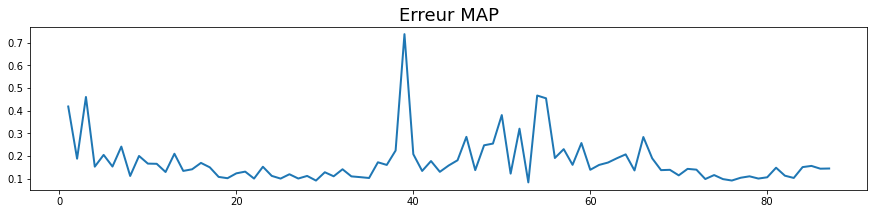

In [43]:
# Modelisation RF
# Systematique
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

gap = 1
horizon = 3 
debut = gap*6*24
fin = debut + horizon*6*24

# Creation du modele
rf = RandomForestRegressor(n_estimators=50, max_features="sqrt", 
                           max_depth=3)

# Nombre de jours passes: historique utilise
p = 29
E2_rf = []
E1_rf = []
Cor_rf = []

# Toutes les prévisions de h+1 à (Période_Max - h)
for i in range(n-h-1):
    k = i + h
    
    y_train = df_charge.iloc[:, k]
    x_train = pd.concat([df_charge.iloc[:, (k-h):(k-1)], 
                     df_temp.iloc[:, (k-h):(k-1)]], axis=1) 
    y_test = df_charge.iloc[:, (k+1)]
    x_test = pd.concat([df_charge.iloc[:, (k-h+1):k],
                     df_temp.iloc[:, (k-h+1):k]], axis=1) 


    x_test.columns = x_train.columns
    rf.fit(x_train, y_train)
    pred = rf.predict(x_test)
    
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 = (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Cor_rf.append(cor[0]) 
    E2_rf.append(err2)
    E1_rf.append(map1)
    
# Résultats performances   
from statistics import mean

plt.figure(figsize=(15, 3))
x = np.linspace(1, len(E1_rf), len(E1_rf))
plt.plot(x, E1_rf, label="erreur", lw=2)
plt.title('Erreur MAP', fontsize=18)

print("RMSE: %.4f" % mean(E2_rf))
print("MAP: %.4f" % mean(E1_rf))
print("Corr: %.4f" % mean(Cor_rf))

plt.show()

## Gradient Boosting

Dans cette partie, à l'aide du module `lightgbm` et de la fonction `LGBMRegressor` vous allez utiliser le gradient boosting pour apprendre la relation entre une courbe de charge $C_k$ à une période $k$ fixée, et l'historique des courbes précédentes $C_{k-1},\dots C_{k-h}$ et des températures précédentes $T_{k-1},\dots T_{k-h}$.

 


### Exercice 10

- Commencez par fixer (arbitrairement) les paramètres de l'algorithme. Vous ferez attention à l'option `num_leaves`de `LGBMRegressor`. Cette option indique le nombre maximal de feuilles des arbres utilisés. Il est important de régler convenablement ce paramètre `num_leaves` plutôt que le paramètre `max_depth`.
- Entraînez le modèle pour une période $k$ fixée et faites la prédiction de la même façon que ci-dessus. En particulier, vous présenterez les mêmes graphiques et les mêmes calculs d'erreurs. 
- Faites varier les paramètres de l'algorithme pour essayer de diminuer les erreurs. On peut également regarder l'importance des variables via l'attribut `feature_importances_` de `LGBMRegressor`. La notion d'importance des variables permet d'indiquer les variables dont l'absence dégraderait la qualité de l'ajustement du modèle. Par défaut,  l'importance d'une variable correspond au nombre de splits dans le modèle où la variable est utilisée.
- Enfin, évaluez la qualité de la méthode en utilisant toutes les valeurs de $k$ possibles (selon la longueur des données dont on dispose).

In [44]:
# Your answer

### Réponse

In [45]:
# Modelisation LightGBM

# Choisir k numero de periode
# Apprendre le lien entre C_k et son passe
# Prevoir C_{k+1}

import lightgbm as lgb

# Numero de colonne du debut la periode d'apprentissage 
k = 22
# Historique utilisé 
h = 4

# Creation du modele
gbm = lgb.LGBMRegressor(objective='regression', # default value
                        num_leaves=10, # c'est pas forcément des souches, default is 31
                        learning_rate=0.05, # default is 0.1
                        feature_fraction = 0.2, # if feature_fraction < 1, use feature sub-sampling : randomly select a subset of features (size defined by feature_fraction) for the splits
                        n_estimators=100, # number of boosting iterations performed.
                       ) 
#gbm = lgb.LGBMRegressor()
y_train = df_charge.iloc[:, k]
x_train = pd.concat([df_charge.iloc[:, (k-h):(k-1)], 
                     df_temp.iloc[:, (k-h):(k-1)]], axis=1) 
y_test = df_charge.iloc[:, (k+1)]
x_test = pd.concat([df_charge.iloc[:, (k-h+1):k],
                     df_temp.iloc[:, (k-h+1):k]], axis=1) 

# attention à vos noms de colonne si vous en avez ! 
x_test.columns = x_train.columns


In [46]:
# entrainement du modèle 
gbm.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


LGBMRegressor(feature_fraction=0.2, learning_rate=0.05, num_leaves=10,
              objective='regression')

RMSE: 10.9493
MAPE: 0.1416
Correlation observation/prevue: 0.8543


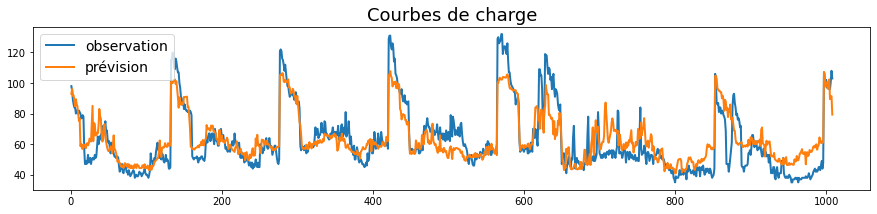

In [47]:
# prédiction sur la semaine suivante
pred = gbm.predict(x_test)

# Calcul des erreurs
rmse = mean_squared_error(y_test, pred) ** 0.5 # racine carrée de l'erreur quadratique
print("RMSE: %.4f" % rmse)
map1 = (abs((pred - y_test) / y_test)).mean()
print("MAPE: %.4f" % map1)
cor = pearsonr(y_test, pred)
print("Correlation observation/prevue: %.4f" % cor[0])


fig = plt.figure(figsize=(15, 3))
x = np.linspace(1, nobs, nobs)
plt.plot(x, y_test, label="observation", lw=2)
plt.plot(x, pred, label="prévision", lw=2)
plt.title('Courbes de charge', fontsize=18)
plt.legend(fontsize=14)
plt.show()

### Recherche des variables les plus "pertinentes" 

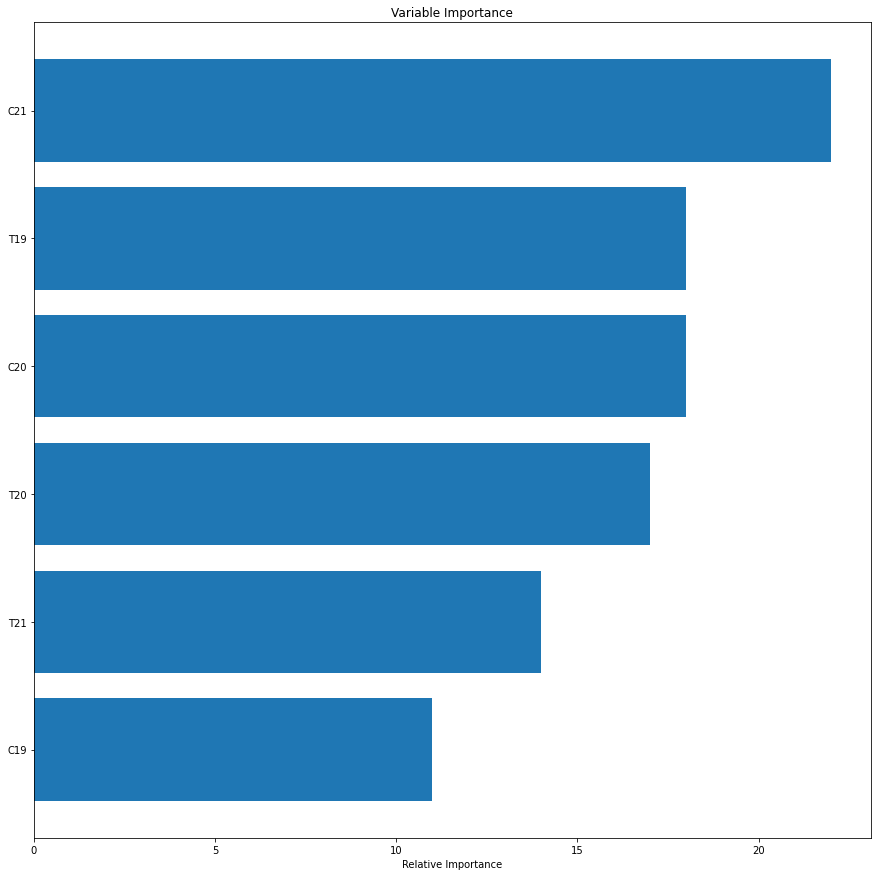

In [48]:
# Importance des variables explicatives
var_importance = gbm.feature_importances_
var_importance = 100.0 * (var_importance / var_importance.sum())
sorted_idx = np.argsort(var_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(15, 15))
plt.barh(pos, var_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

**Attention** : 
    - quand on a beaucoup d'arbres, la notion d'importance de variables est assez robuste à la corrélation entre ces variables. Donc si une variable a une forte importance, c'est qu'elle explique (mieux que les autres) l'observation. Et s'il y a une autre variable très corrélée, elle devrait apparaître comme étant également importante.
    - cependant ici on a utilisé des arbres avec `feature_fraction` de 20\% et 8 variables : donc à chaque split, on tire seulement en moyenne "1,6" variables (donc une ou deux) et on choisit celle qui sépare le mieux les données. Dans ce contexte, l'importance de la variable n'est pas très significative.
    
**Faites tourner à nouveau ce code avec `feature_fraction`=1 et là vous pourrez davantage faire confiance aux variables sélectionnées.**      

### Exercice 11: Détermination des 'meilleurs' paramètres par validation croisée sur une grille

Dernière étape: choisissez les "meilleurs" paramètres de la méthode par validation croisée. On utilisera `GridSearchCV` de `sklearn.model_selection`. Attention à la notion de  "meilleur" !


In [49]:
# Your answer

### Réponse

On utilise `GridSearchCV` pour choisir les "meilleurs" paramètres. Attention, par défaut cette fonction va chercher les meilleurs paramètres au sens du `score` de la classe d'estimateurs sur laquelle on l'applique. Ici, il s'agit de la classe des `LGBMRegressor` et la fonction de score associée à cette fonction est le coefficient de détermination ($R^2$) du problème de régression. Ce n'est pas le choix le plus naturel... 

In [50]:
from sklearn.model_selection import GridSearchCV

estimator = lgb.LGBMRegressor()

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'num_leaves' : [2, 3],
    'feature_fraction' : [0.25,0.5,0.75,1],
}

gbm = GridSearchCV(estimator, param_grid, cv=10)
# cv: default value is 5
# score: default value in LGBMRegressor is R2 coefficient

gbm.fit(x_train, y_train)

print('Les meilleurs paramètres sur la grille sont ', gbm.best_params_)

[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fracti

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGB

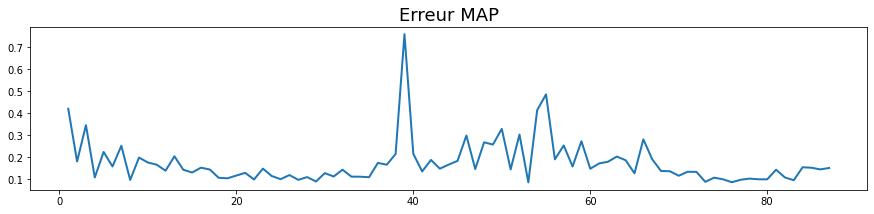

In [51]:
# Modelisation LightGBM
# Systematique
gap = 1
horizon = 3 
debut = gap*6*24
fin = debut + horizon*6*24

# Apprendre le lien Pk et son passe
# Prevoir Pk+1

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=2,
                        learning_rate=0.05,
                        feature_fraction=0.5,
                        n_estimators=100)

# Nombre de jours passes: historique utilise
p = 20
E2_lgbm = []
E1_lgbm = []
Cor_lgbm = []

# Toutes les prévisions de h+1 à (Période_Max - h)
for i in range(n-h-1):
    k = i + h
    
    y_train = df_charge.iloc[:, k]
    x_train = pd.concat([df_charge.iloc[:, (k-h):(k-1)], 
                     df_temp.iloc[:, (k-h):(k-1)]], axis=1) 
    y_test = df_charge.iloc[:, (k+1)]
    x_test = pd.concat([df_charge.iloc[:, (k-h+1):k],
                     df_temp.iloc[:, (k-h+1):k]], axis=1) 
    x_test.columns = x_train.columns
    gbm.fit(x_train, y_train)
    pred = gbm.predict(x_test)
    
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 = (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Cor_lgbm.append(cor[0]) 
    E2_lgbm.append(err2)
    E1_lgbm.append(map1)
    
### Résultats performances    
from statistics import mean

plt.figure(figsize=(15, 3))
x = np.linspace(1, len(E1_lgbm), len(E1_lgbm))
plt.plot(x, E1_lgbm, label="erreur", lw=2)
plt.title('Erreur MAP', fontsize=18)

print("RMSE: %.4f" % mean(E2_lgbm))
print("MAP: %.4f" % mean(E1_lgbm))
print("Corr: %.4f" % mean(Cor_lgbm))

plt.show()

# Comparaison de modèles 

### Exercice 12

Comparez les différents modèles à travers

- les erreurs moyennes : L2, MAP et corrélation
- les erreurs ponctuelles MAP
    

In [52]:
# Your answer

### Réponse

Reg lin : MAP 0.169  RMSE 14.7  corr 0.83
LightGBM : MAP 0.174  RMSE 15.0  corr 0.82
Random Forest : MAP 0.175  RMSE 15.1  corr 0.83


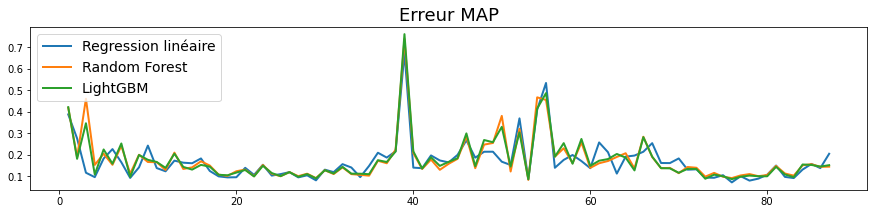

In [53]:
fig = plt.figure(figsize=(15, 3))
x = np.linspace(1, len(E1_rf), len(E1_rf)) 
plt.plot(x, E1_lr[0:len(E1_rf)], label="Regression linéaire", lw=2)
plt.plot(x, E1_rf, label="Random Forest", lw=2)
plt.plot(x, E1_lgbm, label="LightGBM", lw=2)
plt.title('Erreur MAP', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

print("Reg lin : MAP %.3f" % mean(E1_lr)," RMSE %.1f" % mean(E2_lr)," corr %.2f" % mean(Cor_lr))
print("LightGBM : MAP %.3f" % mean(E1_lgbm)," RMSE %.1f" % mean(E2_lgbm)," corr %.2f" % mean(Cor_lgbm))
print("Random Forest : MAP %.3f" % mean(E1_rf)," RMSE %.1f" % mean(E2_rf)," corr %.2f" % mean(Cor_rf))

# Question supplémentaire : apport des températures

On refait tourner sans les températures, pour voir l'apport de ces données "exogènes".

Les modèles sont:

- `reg` : regression lineaire
- `rf` : Random Forest
- `gbm`: boosting par `LightGBM`


In [55]:
gap = 1
horizon = 3 
debut = gap*6*24
fin = debut + horizon*6*24

# Nombre de périodes passes: historique utilise
h = 4    

E2_lr_T = []
E1_lr_T = []
Cor_lr_T = []

E2_rf_T = []
E1_rf_T = []
Cor_rf_T = []

E2_lgbm_T = []
E1_lgbm_T = []
Cor_lgbm_T = []

for i in range(n-h-1):
    k = i + h
    
    y_train = df_charge.iloc[:, k]
    x_train = pd.concat([df_charge.iloc[:, (k-h):(k-1)], 
                     df_temp.iloc[:, (k-h):(k-1)]], axis=1) 
    y_test = df_charge.iloc[:, (k+1)]
    x_test = pd.concat([df_charge.iloc[:, (k-h+1):k],
                     df_temp.iloc[:, (k-h+1):k]], axis=1) 

    x_test.columns = x_train.columns

    # Regression lineaire
    lr.fit(x_train, y_train)  
    pred = lr.predict(x_test) 
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 = (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Cor_lr_T.append(cor[0])
    E2_lr_T.append(err2)
    E1_lr_T.append(map1)

    # Random Forest
    rf.fit(x_train, y_train)
    pred = rf.predict(x_test)
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 = (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Cor_rf_T.append(cor[0])
    E2_rf_T.append(err2)
    E1_rf_T.append(map1)

    # LightGBM
    gbm.fit(x_train, y_train)
    pred = gbm.predict(x_test)
    err2 = mean_squared_error(pred[debut:fin], y_test[debut:fin]) ** 0.5
    map1 = (abs((pred[debut:fin] - y_test[debut:fin]) / y_test[debut:fin])).mean()
    cor = pearsonr(y_test[debut:fin], pred[debut:fin])
    Cor_lgbm_T.append(cor[0]) 
    E2_lgbm_T.append(err2)
    E1_lgbm_T.append(map1)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGB

Reg lin : MAP 0.169  RMSE 14.7  corr 0.83
LightGBM : MAP 0.174  RMSE 15.0  corr 0.82
Random Forest : MAP 0.175  RMSE 15.1  corr 0.83


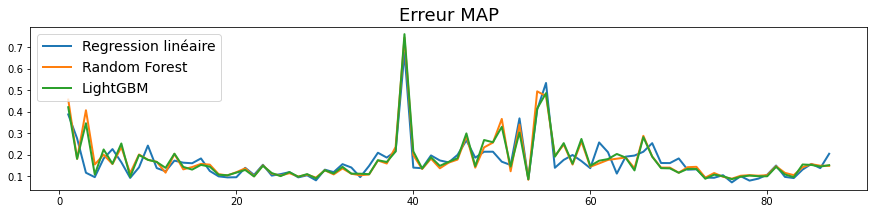

In [56]:
fig = plt.figure(figsize=(15, 3))

x = np.linspace(1, len(E1_rf), len(E1_rf)) 
plt.plot(x, E1_lr_T, label="Regression linéaire", lw=2)
plt.plot(x, E1_rf_T, label="Random Forest", lw=2)
plt.plot(x, E1_lgbm_T, label="LightGBM", lw=2)
plt.title('Erreur MAP', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

print("Reg lin : MAP %.3f" % mean(E1_lr_T)," RMSE %.1f" % mean(E2_lr_T)," corr %.2f" % mean(Cor_lr_T))
print("LightGBM : MAP %.3f" % mean(E1_lgbm_T)," RMSE %.1f" % mean(E2_lgbm_T)," corr %.2f" % mean(Cor_lgbm_T))
print("Random Forest : MAP %.3f" % mean(E1_rf_T)," RMSE %.1f" % mean(E2_rf_T)," corr %.2f" % mean(Cor_rf_T))

Comparaison avec et sans les temperatures

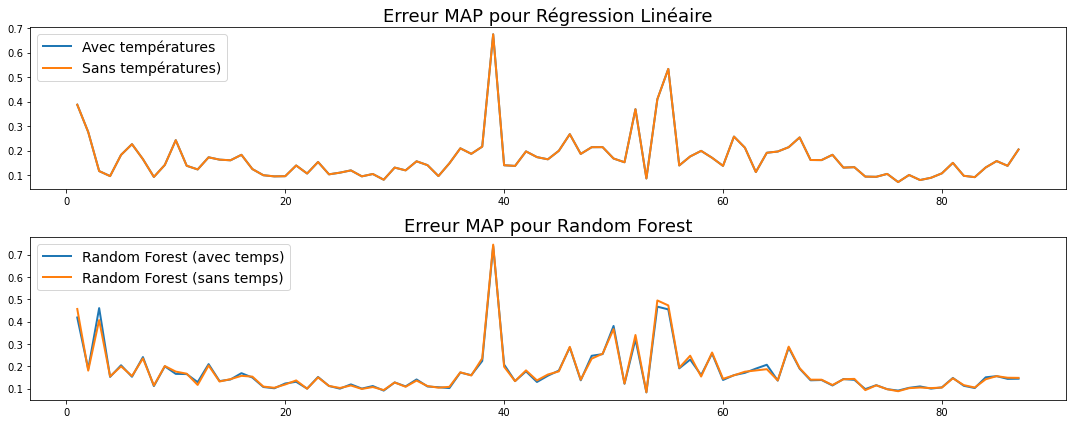

In [57]:
fig = plt.figure(figsize=(15, 6))

x = np.linspace(1, len(E1_rf), len(E1_rf))
plt.subplot(2, 1, 1)

plt.plot(x, E1_lr[0:len(E1_rf)], label="Avec températures", lw=2)
plt.plot(x, E1_lr_T, label="Sans températures)", lw=2)
plt.title('Erreur MAP pour Régression Linéaire', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(x, E1_rf, label="Random Forest (avec temps)", lw=2)
plt.plot(x, E1_rf_T, label="Random Forest (sans temps)", lw=2)
plt.title('Erreur MAP pour Random Forest', fontsize=18)
plt.legend(fontsize=14, loc='upper left')

plt.tight_layout()